# 1. Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install colorama

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from colorama import Fore
import skimage.io as io
import os
import pandas as pd
import random
# torch 
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision.io import read_image
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import torchvision.models as models
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import math
 
import matplotlib.pyplot as plt


In [4]:
%cd /content/drive/MyDrive/domian_adoptation


/content/drive/MyDrive/domian_adoptation


In [5]:
# from  mean_and_std import get_mean_and_std
from dataloader.dataloader import CustomImageDataset ,roteted_dataset
from visualization.data_plot import plot_pic

# 2. parameters

In [6]:
# first set of parameters:
save_dir = '/content/drive/MyDrive/domian_adoptation/result/source_only' 
BATCH_size = 64
dropout = 0.5
weight_rot  = 1
learning_rate = 0.0003
moment = 0.9
W_decay = 0.05
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# second set of parameters:
# save_dir = '/content/drive/MyDrive/domian_adoptation/result/source_only_2' 
# BATCH_size = 64
# dropout = 0.5
# weight_rot  = 1
# learning_rate = 0.0001
# moment = 0.9
# W_decay = 0.05
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)


# third set of parameters:
# save_dir = '/content/drive/MyDrive/domian_adoptation/result/source_only_3' 
BATCH_size = 64
dropout = 0.2
weight_rot  = 1
learning_rate = 0.0003
moment = 0.9
W_decay = 0.05
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0
cuda:0


# 3. Datasets




In [7]:
# ! wget 'https://www.dropbox.com/s/xdy5cfu7m63pk46/?dl=1' -O \ ROD-synROD.tar
# ! rm ' ROD-synROD.tar'
# !  cp ' ROD-synROD.tar'  /content/drive/MyDrive/domian_adoptation


In [8]:
if not os.path.isfile('/content/ROD-synROD/ROD/rgb-washington/apple/apple_1/apple_1_1_101_crop.png'):
        print(Fore.RED, 'This might take several minuets......')
        ! tar -xf     /content/drive/MyDrive/domian_adoptation/' ROD-synROD.tar'  -C /content
       
else:
         print(Fore.CYAN, 'dataset file already exist')


 This might take several minuets......


# 2.1 ROD dataset


---



1.   Rod without label as a trainset
2.   Rod with label as testset






In [9]:
with open("/content/ROD-synROD/ROD/wrgbd_40k-split_sync.txt") as f:
 
    lines = f.read() 
    imgs = lines.split('\n')
imgs.remove('')
print(imgs[0])

all_labels = [imgs[i].split('/')[0] for i in range(len(imgs))]
all_labels=list(set(all_labels))
labelmap ={}
for i in range(len(all_labels)):
   labelmap[all_labels[i]] =i
print('total number of labels: ',Fore.RED,len(labelmap) )
print(Fore.BLUE,labelmap)

ROD_dataset = CustomImageDataset(dt= 'ROD',annotations_list = imgs,label_map=labelmap,
                                img_dir ="/content/ROD-synROD/ROD/rgb-washington",
                                depth_dir ="/content/ROD-synROD/ROD/surfnorm-washington",
                                transform = transforms.Compose([
                                transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),    
                                transforms.Normalize(mean=[0.5547, 0.5310, 0.5189], std=[0.2122, 0.2184, 0.2499],)  ]), 
                                # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225],)  ]),
                                                                                        
                                transform_d = transforms.Compose([
                                transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),    
                                transforms.Normalize(mean=[0.7426, 0.2956, 0.4785], std=[0.2012, 0.2030, 0.2916],)   ]) 
                                # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225],)  ]),
                                                     
                                    
                                )

ROD_dataloader = DataLoader(ROD_dataset, batch_size= BATCH_size,shuffle=True)


rubber_eraser/rubber_eraser_4/rubber_eraser_4_1_136_***.png 38
total number of labels:   47
 {'dry_battery': 0, 'food_cup': 1, 'lemon': 2, 'greens': 3, 'scissors': 4, 'coffee_mug': 5, 'comb': 6, 'calculator': 7, 'hand_towel': 8, 'sponge': 9, 'cereal_box': 10, 'mushroom': 11, 'cell_phone': 12, 'marker': 13, 'garlic': 14, 'keyboard': 15, 'bowl': 16, 'pear': 17, 'pitcher': 18, 'binder': 19, 'water_bottle': 20, 'glue_stick': 21, 'food_box': 22, 'food_jar': 23, 'stapler': 24, 'toothpaste': 25, 'camera': 26, 'potato': 27, 'notebook': 28, 'cap': 29, 'shampoo': 30, 'kleenex': 31, 'banana': 32, 'food_can': 33, 'bell_pepper': 34, 'apple': 35, 'food_bag': 36, 'toothbrush': 37, 'flashlight': 38, 'instant_noodles': 39, 'soda_can': 40, 'lightbulb': 41, 'rubber_eraser': 42, 'ball': 43, 'plate': 44, 'orange': 45, 'pliers': 46}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

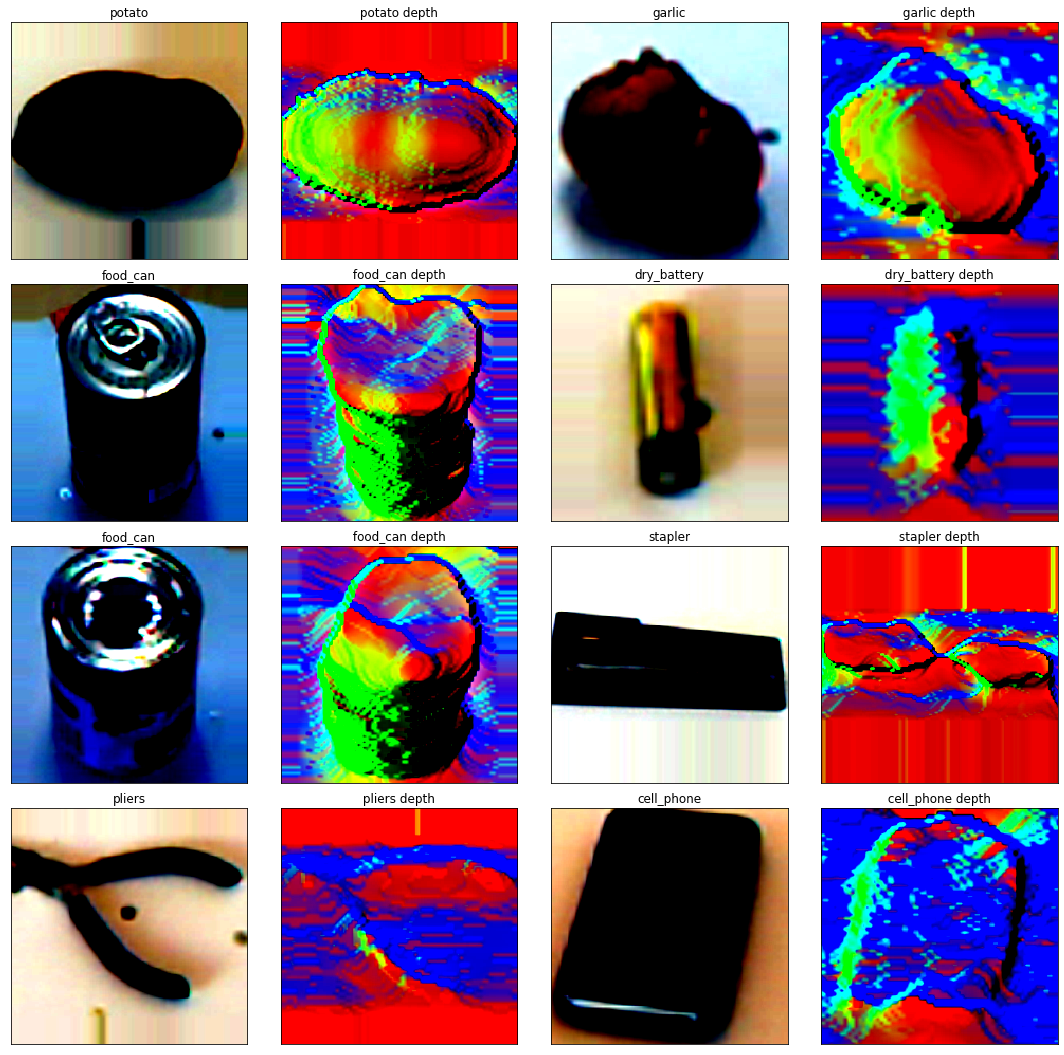

In [10]:
# visulasioan of ROD
X  = plot_pic(ROD_dataloader,labelmap)
X.savefig('ROD')

In [11]:


labelmap_rorated = {
    '0 degree' :0,
    '90 degree' :1,
    '180 degree' :2,
    '270 degree' :3

}


# 2.2 SynROD dataset


---



1.   SynROD  with label as a trainset



In [12]:
with open("/content/ROD-synROD/synROD/synARID_50k-split_sync_train1.txt") as f:
    lines = f.read() 
    syn_imgs = lines.split('\n')
syn_imgs.remove('')

with open("/content/ROD-synROD/synROD/synARID_50k-split_sync_test1.txt") as f:
    lines = f.read() 
    syn_imgs_test = lines.split('\n')
# syn_imgs.remove('')

syn_imgs_test.remove('')


syn_all_labels = [syn_imgs[i].split('/')[0] for i in range(len(syn_imgs))]
syn_all_labels=list(set(syn_all_labels))

syn_all_labels_test = [syn_imgs_test[i].split('/')[0] for i in range(len(syn_imgs_test))]
syn_all_labels_test=list(set(syn_all_labels_test))

# checking labesls oncistency 
if set(syn_all_labels) == set(syn_all_labels_test):
  print('rod and synrod labels match')
else :
  for i in syn_all_labels :
    if i not in  syn_all_labels_test:
      print(i,"exist in synrod trainset but not testset")
  for i in syn_all_labels_test :
    if i not in  syn_all_labels:
      print(i," exist in synrod testset but not trainset")

if set(syn_all_labels) == set(all_labels):
  print(' datasets labels completly match')
else:
  print('sth is wrong')
  for i in syn_all_labels :
    if i not in  all_labels:
      print(i,"does not exist in ROD")
  for i in all_labels :
    if i not in  syn_all_labels:
      print(i," does not exist in synrod")


rod and synrod labels match
sth is wrong
bell_papper does not exist in ROD
bell_pepper  does not exist in synrod


In [13]:
SynROD_train = CustomImageDataset(dt = 'SYNROD',annotations_list = syn_imgs,label_map=labelmap,
                                  img_dir ='/content/ROD-synROD/synROD',depth_dir ="/content/ROD-synROD/synROD",
                                transform = transforms.Compose([
                                transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),    
                                transforms.Normalize(mean=[0.3107, 0.2884, 0.2595], std=[0.2352, 0.2268, 0.2336],)]),
                                # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225],)  ]),

                                transform_d = transforms.Compose([
                                transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),    
                                transforms.Normalize(mean=[0.4422, 0.4014, 0.6852], std=[0.1382, 0.2507, 0.3628],)   ]))
                                # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225],)  ]))

   

SynROD_test = CustomImageDataset(dt = 'SYNROD',annotations_list = syn_imgs_test,label_map=labelmap,img_dir ='/content/ROD-synROD/synROD',
                                 depth_dir ="/content/ROD-synROD/synROD",
         transform = transforms.Compose([
                                transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),    
                                transforms.Normalize(mean=[0.3107, 0.2884, 0.2595], std=[0.2352, 0.2268, 0.2336],)]),

                                transform_d = transforms.Compose([
                                transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),    
                                transforms.Normalize(mean=[0.4422, 0.4014, 0.6852], std=[0.1382, 0.2507, 0.3628],)   ]))





SynROD_dataloader_train = DataLoader(SynROD_train, batch_size=BATCH_size,shuffle=True)

SynROD_dataloader_test = DataLoader(SynROD_test, batch_size=BATCH_size,shuffle=True)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

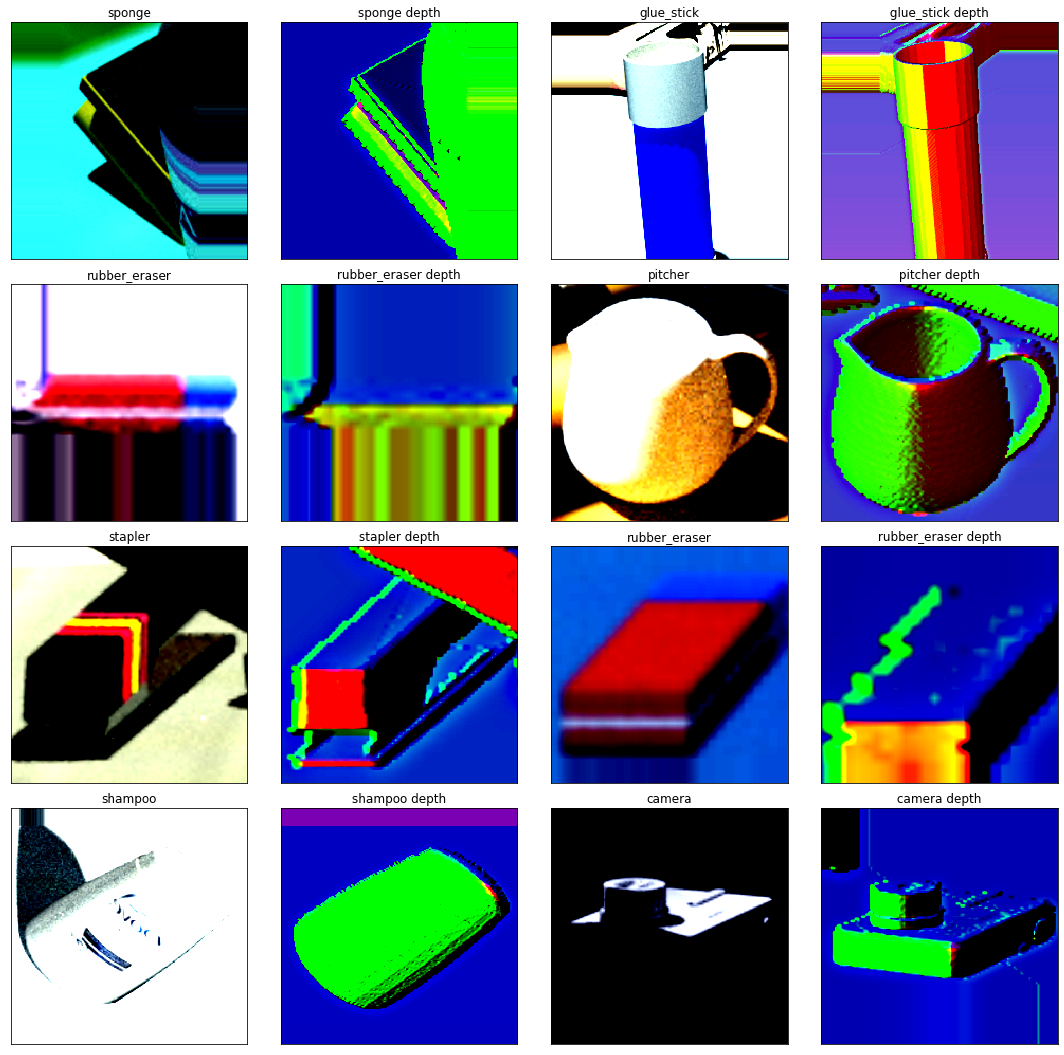

In [14]:
SynROD_rotated = roteted_dataset(dt = 'SYNROD',annotations_list = syn_imgs,
                                 img_dir ='/content/ROD-synROD/synROD',depth_dir ="/content/ROD-synROD/synROD",
                                transform = transforms.Compose([
                                transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),    
                                transforms.Normalize(mean=[0.3107, 0.2884, 0.2595], std=[0.2352, 0.2268, 0.2336],)]),
                                # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225],)  ]),
                                 
                                transform_d = transforms.Compose([
                                transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),    
                                # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225],)  ]))
                                transforms.Normalize(mean=[0.4422, 0.4014, 0.6852], std=[0.1382, 0.2507, 0.3628],)   ]))

SynROD_rotated_dataloader = DataLoader(SynROD_rotated, batch_size=BATCH_size,shuffle=True)

X  = plot_pic(SynROD_dataloader_train ,labelmap)
# X.savefig('SynROD')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

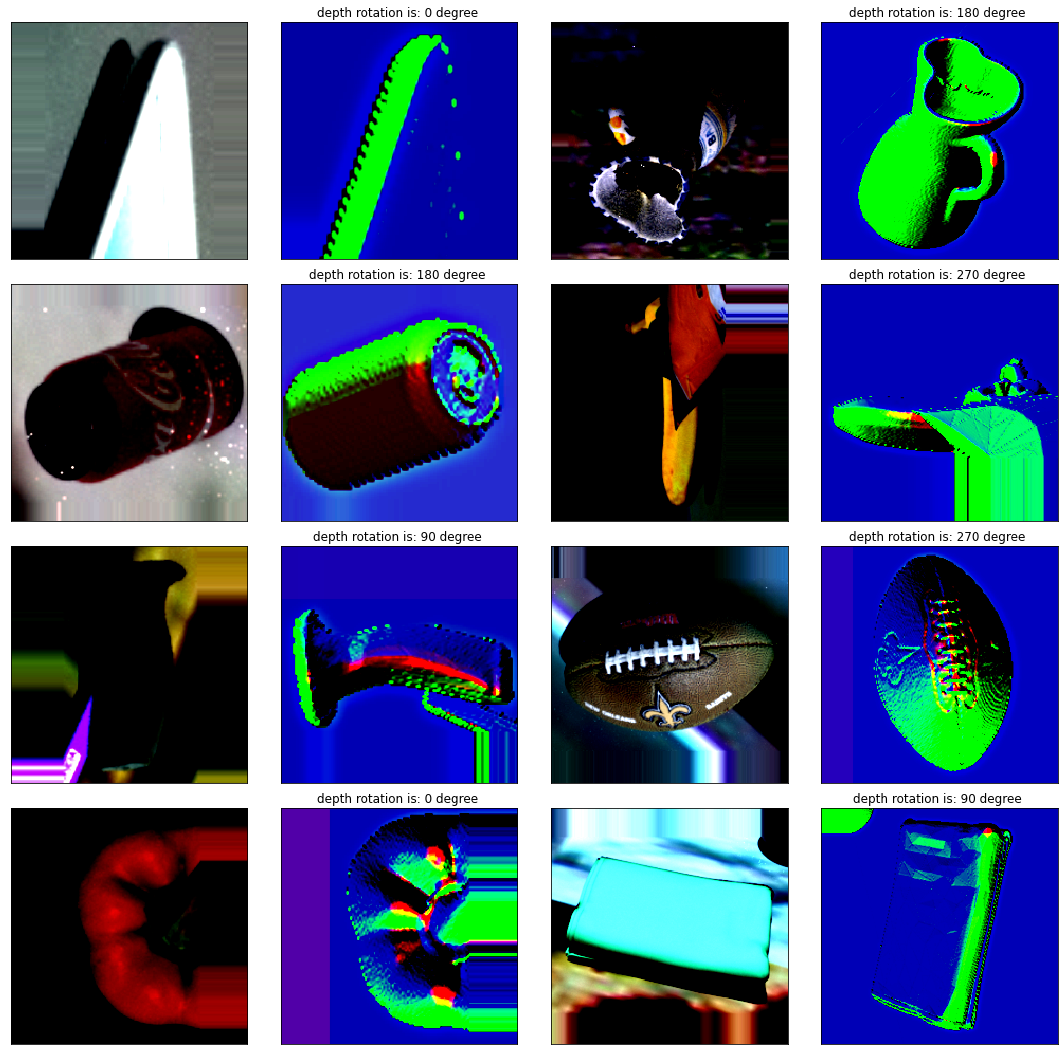

In [15]:
X  = plot_pic(SynROD_rotated_dataloader ,labelmap_rorated,r =True)
# X.savefig('SynROD_rotated')


# models

In [16]:
# helper function
def load_cnn_model(model_name, pretrained=True):
    "Load and return a convolutional neural network."
    assert model_name in ['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152']
    return models.__dict__[model_name](pretrained= True)
    

In [17]:
class E(nn.Module):
    def __init__(self, model_name):
      
        super(E, self).__init__()  
        # load cnn and remove 2 last layers
        cnn = load_cnn_model(model_name)
        modules = list(cnn.children())[:-2]  # remove 2 last layers
        
        self.cnn = nn.Sequential(*modules)             
    
        
    def forward(self, x):
        x = self.cnn(x)  
              
        return x

class feature_extract(nn.Module):
    def __init__(self):
      
        super(feature_extract, self).__init__()  
        self.E_c = E(model_name ='resnet18')
        self.E_d = E(model_name ='resnet18') 
                
    def forward(self,  images, depths):
        features_c = self.E_c(images)
        features_d = self.E_d(depths)        
        X = torch.cat([features_c,features_d], dim=1 )     
              
        return X

class main_head(nn.Module):
    def __init__(self,num_classes,dropout):
      super(main_head, self).__init__() 
      self.gap = nn.AdaptiveAvgPool2d(output_size=(1, 1)) 

      self.fc1 = nn.Sequential(
          nn.Dropout(dropout),
          nn.Linear(1024, 1000),
          nn.BatchNorm1d(1000, affine=True),
          nn.ReLU(inplace=True),
          nn.Dropout(dropout)
      )
      self.fc2 = nn.Linear(1000, num_classes)
      self.initilise_weight()
      

    def forward(self, features):
        x = self.gap(features)
        x = torch.squeeze(x)
        x = self.fc1(x)
        x = self.fc2(x)   
        # x = F.softmax(x, dim=1)   
          
              
        return x
    
    def initilise_weight(self):
        for m in self.modules():
          if isinstance(m,nn.Conv2d):
             torch.nn.init.xavier_uniform_(m.weight)
             torch.nn.init.zeros_(m.bias)
          if isinstance(m,nn.BatchNorm1d):
               m.weight.data.normal_(1.0, 0.01)
               m.bias.data.fill_(0)
          if isinstance(m,nn.BatchNorm2d):
               m.weight.data.normal_(1.0, 0.01)
               m.bias.data.fill_(0)
          if  isinstance(m,nn.Linear):
               m.weight.data.normal_(0.0, 0.01)
               m.bias.data.normal_(0.0, 0.01)


     

class pretext(nn.Module):
    def __init__(self,dropout):
      super(pretext, self).__init__() 
      self.p_conv_1x1 = nn.Sequential(
          nn.Conv2d(1024 ,100, [1,1], stride=[1,1]),
          nn.BatchNorm2d(100),
          nn.ReLU(inplace=True),
          nn.Dropout(dropout)
          )
      self.p_conv_3x3 = nn.Sequential(
          nn.Conv2d(100, 100, [3,3], stride=[2,2]),
          nn.BatchNorm2d(100),
          nn.ReLU(inplace=True),
          nn.Dropout(dropout)
          )
      self.p_fc1 = nn.Sequential(
          nn.Linear(100*3*3, 100),
          nn.BatchNorm1d(100, affine=True),
          nn.ReLU(inplace=True),
          nn.Dropout(dropout)
          )
      self.p_fc2 = nn.Linear(100, 4)
      self.initilise_weight()
      
     
      

    def forward(self, features):
      
        y = self.p_conv_1x1(features)
        y = self.p_conv_3x3(y)
        y = y.view(y.size(0), -1)
        y = self.p_fc1(y)
        y = self.p_fc2(y)
      
      #  y = F.softmax(y, dim=1) 
       
        return y


    def initilise_weight(self):
        for m in self.modules():
          if isinstance(m,nn.Conv2d):
             torch.nn.init.xavier_uniform_(m.weight)
             torch.nn.init.zeros_(m.bias)
          if isinstance(m,nn.BatchNorm1d):
               m.weight.data.normal_(1.0, 0.01)
               m.bias.data.fill_(0)
          if isinstance(m,nn.BatchNorm2d):
               m.weight.data.normal_(1.0, 0.01)
               m.bias.data.fill_(0)
          if  isinstance(m,nn.Linear):
               m.weight.data.normal_(0.0, 0.01)
               m.bias.data.normal_(0.0, 0.01)

F_model = feature_extract()

main_model =  main_head(num_classes = len(labelmap),dropout =dropout)

# pr_model =  pretext(dropout =dropout)





/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

# model training


In [18]:
loss_fn_1 = torch.nn.CrossEntropyLoss()

optimizer1 = torch.optim.SGD(F_model.parameters(), lr=learning_rate, momentum=moment,weight_decay=W_decay)
optimizer2 = torch.optim.SGD(main_model.parameters(), lr=learning_rate, momentum=moment,weight_decay=W_decay)
# optimizer3 = torch.optim.SGD(pr_model.parameters(), lr=learning_rate, momentum=moment,weight_decay=W_decay)


In [19]:
F_model.to(device)
main_model.to(device)
# pr_model.to(device)


main_head(
  (gap): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=1024, out_features=1000, bias=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace=True)
    (4): Dropout(p=0.2, inplace=False)
  )
  (fc2): Linear(in_features=1000, out_features=47, bias=True)
)

In [20]:
swtt_batch = math.ceil(len(syn_imgs)/BATCH_size)
def train_one_epoch(epoch_index, tb_writer):
    running_loss_1 = 0.
    last_loss_1 = 0.
    running_loss_2 = 0.
    last_loss_2 = 0.
    acc = 0
    tot = 0
    cor = 0
    acc2 = 0
    tot2 = 0
    cor2 = 0
    training_loss = 0

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(SynROD_dataloader_train ,0):


      # Zero your gradients for every batch!
        optimizer1.zero_grad()
        optimizer2.zero_grad()
        
       
       
        image_s,depth_s,label_s = data
        image_s,depth_s,label_s = image_s.to(device),depth_s.to(device),label_s.to(device)
        

        # Make predictions for this batch
        feat = F_model(image_s,depth_s)
        outputs = main_model(feat)
          
        

        loss_1 = loss_fn_1(outputs,label_s) 
       
       
        pr =  F.softmax(outputs, dim=1) 
        _, pr= torch.max( pr.data, 1)
        _, real= torch.max(label_s.data, 1)

        tot += label_s.size(0)
        cor += (pr ==  real).sum().item()
        acc = 100 * cor / tot    

        # image_s_r,depth_s_r,rotation_syn = next(iter(SynROD_rotated_dataloader))
             
        
        # image_s_r,depth_s_r,rotation_syn =  image_s_r.to(device),depth_s_r.to(device),rotation_syn.to(device)      
      
        # feat2 = F_model( image_s_r,depth_s_r)
       
        
        # outputs2 =pr_model( feat2 )        
        
       
        # loss_2 = loss_fn_1(outputs2,rotation_syn) 

        loss =  loss_1
        
                            
          
        loss.backward()
        running_loss = loss_1.item() 
        training_loss   +=  loss_1.item()
        optimizer1.step()
        optimizer2.step()
        # optimizer3.step()   
               

        if i % 50 == 49:
          last_loss = running_loss / 50 # loss per batch
          
          print(Fore.CYAN,'  batch {}/ {} source_train_loss: {}  and source_train_acc is {}   time is {}'.format(i + 1,swtt_batch, '%.6f' % last_loss, '%.4f'% acc,'%.2f' %(time.time() - start_time)))
          
          running_loss = 0.
         
        
    
   
    # model_name = F_model.module._get_name() if isinstance(F_model, torch.nn.DataParallel) else F_model._get_name()
    # checkpoint1 = {'epoch':epoch,
    #               'model_state_dict': F_model.state_dict(),
    #               'optimizer_state_dict': optimizer1.state_dict(),
    #                'loss':  loss
    #                  }
    # fpath = f'{save_dir}/{model_name}_checkpoint_dict.pt'
    # torch.save(checkpoint1,fpath)

    # model_name = main_model.module._get_name() if isinstance(main_model, torch.nn.DataParallel) else main_model._get_name()
    # checkpoint1 = {'epoch':epoch,
    #               'model_state_dict': main_model.state_dict(),
    #               'optimizer_state_dict': optimizer2.state_dict(),
    #                'loss':  loss
    #                  }
    # fpath = f'{save_dir}/{model_name}_checkpoint_dict.pt'
    # torch.save(checkpoint1,fpath)

    # model_name = pr_model.module._get_name() if isinstance(pr_model, torch.nn.DataParallel) else F_model._get_name()
    # checkpoint2 = {'epoch':epoch,
    #               'model_state_dict': pr_model.state_dict(),
    #               'optimizer_state_dict': optimizer3.state_dict(),
    #                'loss':  loss
                   
    #                  }
    # fpath = f'{save_dir}/{model_name}_checkpoint_dict.pt'
    # torch.save(checkpoint2,fpath)
    



    return  training_loss/(i + 1),acc 

In [ ]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/ROD_{}'.format(timestamp))
epoch_number = 0
import time
start_time = time.time()

EPOCHS = 20
best_vloss = 1_000_000.

source_train_loss =[]
source_train_accuracy =[]

source_test_loss =[]
source_test_accuracy =[]



target_test_loss = []
target_test_accuracy =[]


for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    F_model.train(True)
    main_model.train(True)
   
   

    avg_loss, test_acc= train_one_epoch(epoch_number, writer)
    source_train_loss.append(avg_loss)
    source_train_accuracy.append(test_acc)

    # We don't need gradients on to do reporting
    F_model.train(False)
    main_model.train(False)

    running_vloss = 0.0
    correct =0
    total = 0.
    
    for i, vdata in enumerate(SynROD_dataloader_test ):
        with torch.no_grad():
          v_image,v_depth, vlabels = vdata
          v_image,v_depth, vlabels =  v_image.to(device),v_depth.to(device), vlabels.to(device)
          feat_o  = F_model(v_image,v_depth)
          voutputs= main_model(feat_o)
           
          vloss = loss_fn_1(voutputs, vlabels)
          running_vloss += vloss

          _, predicted = torch.max(voutputs.data, 1)
          _, real_label = torch.max(vlabels.data, 1)
          total += vlabels.size(0)
          correct += (predicted ==real_label).sum().item()
         
    accuracy = 100 * correct / total
    avg_vloss = running_vloss / (i + 1)
    source_test_loss.append(avg_vloss)
    source_test_accuracy.append(accuracy)


    print(Fore.GREEN,'for main taks,loss source_test {},..... acc source_test {}'.format(avg_vloss, accuracy))   
   

    running_vloss = 0.0
    correct =0
    total = 0.
    
    for i, vdata in enumerate(ROD_dataloader):
        with torch.no_grad():
          v_image,v_depth, vlabels = vdata
          v_image,v_depth, vlabels =  v_image.to(device),v_depth.to(device), vlabels.to(device)
          feat_o  = F_model(v_image,v_depth)
          voutputs= main_model(feat_o)
           
          vloss = loss_fn_1(voutputs, vlabels)
          running_vloss += vloss

          _, predicted = torch.max(voutputs.data, 1)
          _, real_label = torch.max(vlabels.data, 1)
          total += vlabels.size(0)
          correct += (predicted ==real_label).sum().item()
         
    accuracy = 100 * correct / total
    avg_vloss = running_vloss / (i + 1)
    target_test_loss.append(avg_vloss)
    target_test_accuracy.append(accuracy)

    print(Fore.RED,'for main taks, loss target_test {} , .... acc target_test {}'.format( avg_vloss, accuracy))
    
    E= [i for i in range(len(target_test_loss))]

    fig, (axs, ax2) = plt.subplots(2)
    t_target_loss = [target_test_loss[i].cpu()  for i  in range(len(target_test_loss))]
    s_test_loss =  [source_test_loss[i].cpu()  for i  in range(len(target_test_loss))]

    axs.plot(E, t_target_loss,label="target")
    axs.plot(E,s_test_loss,label="source_test")
    
    axs.set_xlabel('epoch')
    axs.set_ylabel('loss')
    axs.grid(True)

    # t_target_acc = [target_test_accuracy[i].cpu()  for i  in range(len(target_test_loss))]
    # s_test_acc =  [source_test_accuracy[i].cpu()  for i  in range(len(target_test_loss))]

    ax2.plot(E, target_test_accuracy,label="target" )
    ax2.plot(E,source_test_accuracy,label="source_test")

    
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('accuracy')
    ax2.grid(True)

    fig.tight_layout()
   
    plt.savefig('source_only.png')
  

    # Track best performance, and save the model's state
    # if avg_vloss < best_vloss:
    #     best_vloss = avg_vloss
    #     F_model_path = 'result/source_only_2/F_model_{}_{}'.format(timestamp, epoch_number)
    #     torch.save(F_model.state_dict(), F_model_path)

    #     M_model_path = 'result/source_only_2/main_model_{}_{}'.format(timestamp, epoch_number)
    #     torch.save(main_model.state_dict(), M_model_path)

    #     Fr_model_path = 'result/source_only_2/pr_model_{}_{}'.format(timestamp, epoch_number)
    #     torch.save(pr_model.state_dict(),Fr_model_path)

   



      

    epoch_number += 1

EPOCH 1:
   batch 50/ 586 source_train_loss: 0.073900  and source_train_acc is 4.7812   time is 59.02
   batch 100/ 586 source_train_loss: 0.070549  and source_train_acc is 9.4531   time is 103.82
   batch 150/ 586 source_train_loss: 0.068014  and source_train_acc is 14.2708   time is 146.34
   batch 200/ 586 source_train_loss: 0.065809  and source_train_acc is 19.3281   time is 189.10
   batch 250/ 586 source_train_loss: 0.059402  and source_train_acc is 23.8250   time is 230.41
   batch 300/ 586 source_train_loss: 0.059225  and source_train_acc is 27.7188   time is 270.99
   batch 350/ 586 source_train_loss: 0.053191  and source_train_acc is 31.1116   time is 312.26
   batch 400/ 586 source_train_loss: 0.054591  and source_train_acc is 34.0781   time is 352.35
   batch 450/ 586 source_train_loss: 0.048852  and source_train_acc is 36.6042   time is 392.75
   batch 500/ 586 source_train_loss: 0.050363  and source_train_acc is 38.9188   time is 434.09
   batch 550/ 586 source_train_loss